# Imports

In [16]:
import numpy as np
from IPython.display import display, Markdown
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
import wandb
from tensorflow.keras.utils import plot_model
from wandb.integration.keras import WandbCallback
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pydot

# Load Data

In [2]:
data_dir = '../data/processed'

# Load the training data
X_train = np.load(data_dir+'/X_train.npy')
y_train = np.load(data_dir+'/y_train.npy')

# Load the validation data
X_val = np.load(data_dir+'/X_val.npy')
y_val = np.load(data_dir+'/y_val.npy')

# Load the test data
X_test = np.load(data_dir+'/X_test.npy')
y_test = np.load(data_dir+'/y_test.npy')

display(Markdown(f"**Training set:** {X_train.shape}, {y_train.shape}"))
display(Markdown(f"**Validation set:** {X_val.shape}, {y_val.shape}"))
display(Markdown(f"**Test set:** {X_test.shape}, {y_test.shape}"))


**Training set:** (693, 128, 128, 3, 1), (693, 10)

**Validation set:** (148, 128, 128, 3, 1), (148, 10)

**Test set:** (149, 128, 128, 3, 1), (149, 10)

# Create Model


In [3]:
class CustomWandbCallback(Callback):
    def on_train_begin(self, logs=None):
        self.run = wandb.init(project="music-genre-classification", reinit=True)

    def on_train_end(self, logs=None):
        wandb.finish()

    def on_epoch_end(self, epoch, logs=None):
        wandb.log(logs)

In [4]:
# Initialize W&B project
wandb.init(project="music-genre-classification", reinit=True)

# Hyperparameters
config = wandb.config
config.epochs = 10
config.batch_size = 32

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nicola-reichert (nicola-reichert1). Use `wandb login --relogin` to force relogin


In [10]:
class CNNHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        
        # Input layer
        model.add(Input(shape=(128, 128, 3)))
        
        # Convolutional Block 1
        model.add(Conv2D(filters=hp.Choice('filters1', [32, 64]), kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.2))
        
        # Convolutional Block 2
        model.add(Conv2D(filters=hp.Choice('filters2', [64, 128]), kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.2))
        
        # Convolutional Block 3
        model.add(Conv2D(filters=hp.Choice('filters3', [128, 256]), kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.2))
        
        # Convolutional Block 4
        model.add(Conv2D(filters=hp.Choice('filters4', [256, 512]), kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.2))
        
        # Convolutional Block 5
        model.add(Conv2D(filters=hp.Choice('filters5', [256, 512]), kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.2))
        
        # Flatten and Fully Connected Layer
        model.add(Flatten())
        model.add(Dense(10, activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        return model

In [11]:
# Initialize the hypermodel
hypermodel = CNNHyperModel()

In [12]:
# Initialize the tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='music_genre_classification'
)

# Display search space summary
tuner.search_space_summary()

Reloading Tuner from hyperparameter_tuning/music_genre_classification/tuner0.json
Search space summary
Default search space size: 5
filters1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
filters2 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
filters3 (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256], 'ordered': True}
filters4 (Choice)
{'default': 256, 'conditions': [], 'values': [256, 512], 'ordered': True}
filters5 (Choice)
{'default': 256, 'conditions': [], 'values': [256, 512], 'ordered': True}


In [13]:
# Perform the search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[CustomWandbCallback()])

In [14]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Display model summary
best_model.summary()


/Users/nicola/Documents/GitHub/Music-Genre-Classification---GTZAN/venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,034,442 (7.76 MB)

 Trainable params: 2,034,442 (7.76 MB)

 Non-trainable params: 0 (0.00 B)

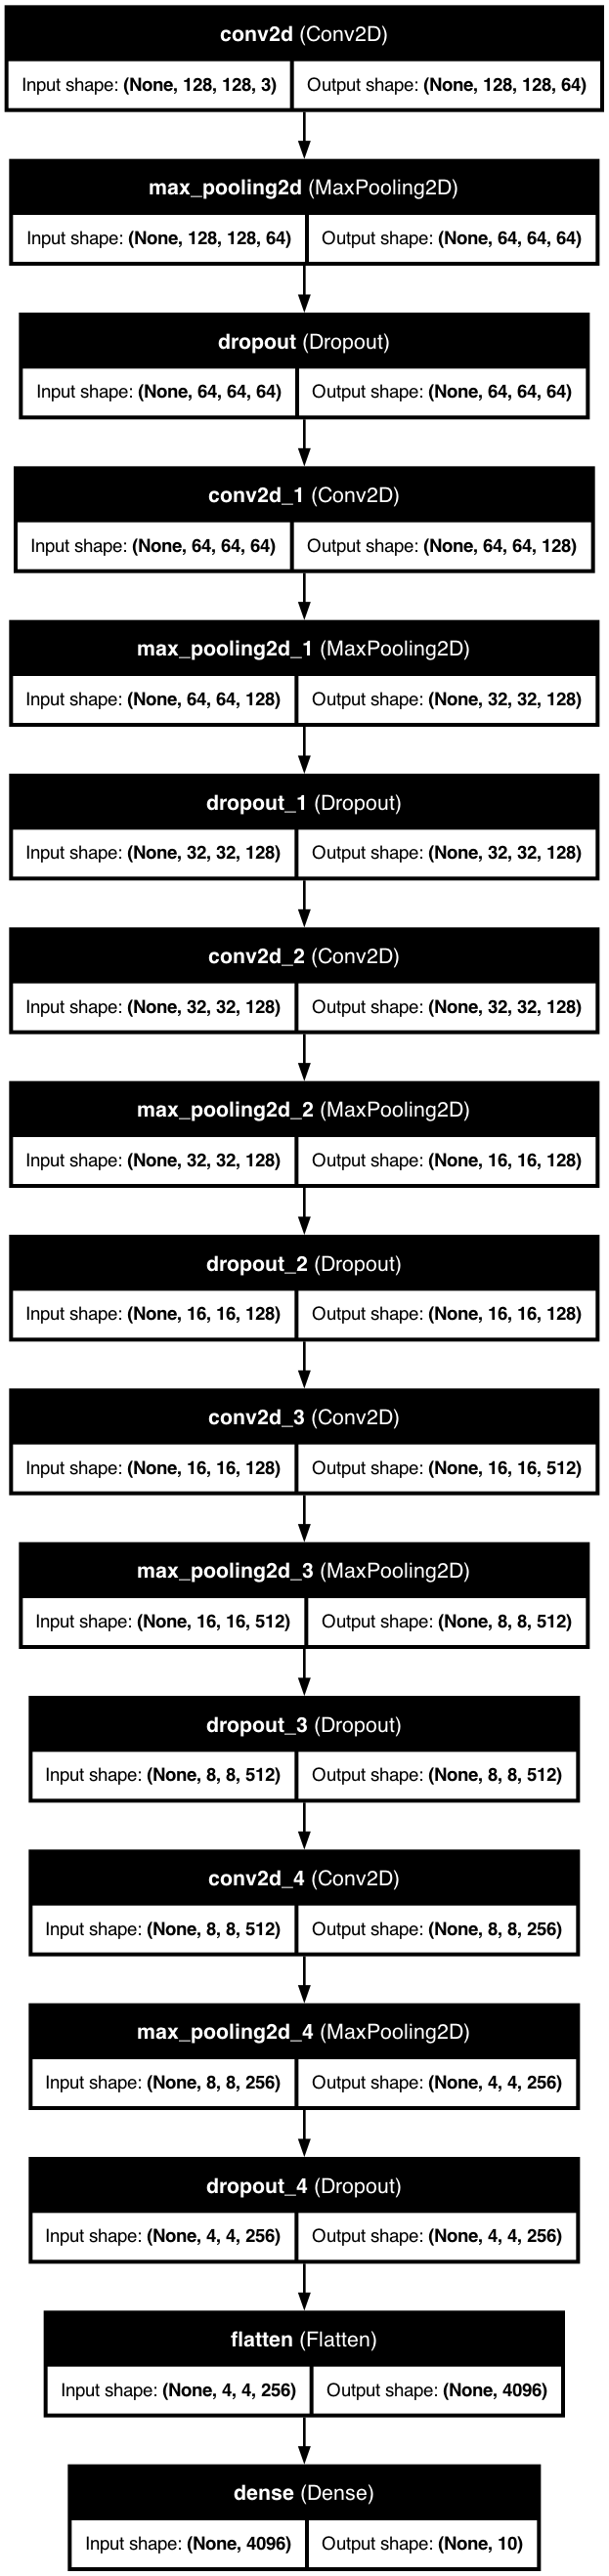

wandb: Network error (ConnectionError), entering retry loop.


In [20]:
plot_model(best_model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=96)


# Evaluation

In [ ]:
y_pred = best_model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


In [ ]:
# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

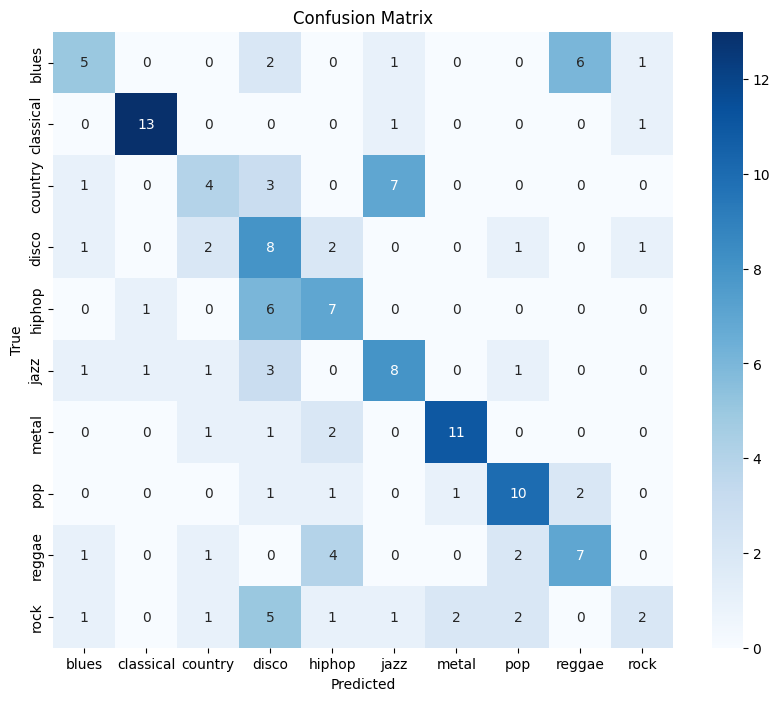

In [ ]:
# Define the class names
class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Evaluate the best model on the test set
test_loss, test_acc = best_model.evaluate(X_test, y_test)

print(f"Test accuracy: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.4955 - loss: 1.5142
Test accuracy: 0.5033556818962097
